In [1]:
import numpy as np
import itertools as itt
import time
import matplotlib.pyplot as plt
from PIL import Image

## Trabalho 2 - Cálculo Numérico

Jorge Augusto Salgado Salhani

Nro USP: 8927418

Também disponível em (GitHub): https://github.com/jorgesalhani/numericalAnalysis/tree/main/T2

Ou também (Google Colab): 

#### Questão 1 (SVD)

Abaixo implementamos a classe EigenV, com métodos responsáveis por executar operações relacionadas ao cálculo de autovalores e autovetores de uma matriz

In [127]:
"""
Classe EigenV

Cálculo de autovalores-autovetores de uma matriz
"""
class EigenV:
  def __init__(self, max_it = 1000, tol = 0.001) -> None:
    """ Construtor

    :param max_it: int 
      Máximo de iterações para convergência para um valor de tolerancia
    :param tol : float 
      Valor de tolerancia para término de cômputo das funções
    """
    self.tol = tol
    self.max_it = max_it

  @staticmethod
  def decomposition_QR_classic(A):
    """ Decomposição de matrix via método QR classico
    A = QR

    :param A: ndarray 
      numpy 2D array
    :returns: {Q:Q, R:R}
    """
    m,n = [len(A), len(A[0])]

    Q = np.zeros((m,n))
    R = np.zeros((n,n))

    for j in range(n):
      V = A[:,j]
      
      for i in range(j):
        R[i,j] = np.dot(Q[:,i].transpose(), A[:,j])
        V = V - R[i,j] * Q[:, i]

      R[j,j] = np.linalg.norm(V)
      Q[:,j] = V / R[j,j]

    return {'Q': Q, 'R': R}

  @staticmethod
  def decomposition_QR_modified(A):
    """ Decomposição de matrix via método QR modificado
    A = QR

    :param A: ndarray 
      numpy 2D array
    :returns: {Q:Q, R:R}
    """
    m,n = [len(A), len(A[0])]

    V = np.copy(A)
    Q = np.zeros((m,n))
    R = np.zeros((n,n))

    for j in range(n):
      R[j,j] = np.linalg.norm(V[:,j])
      Q[:,j] = V[:,j] / R[j,j]
      
      for i in range(j, n):
        R[j,i] = np.dot(Q[:,j], V[:,i])
        V[:,i] = V[:,i] - R[j,i] * Q[:,j]

    return {'Q': Q, 'R': R}

  def francis(self, A):
    """ Determinação de autovetores (V) e matriz diagonal de autovalores (D) via método de Francis

    :param A: ndarray 
      numpy 2D array
    :returns: {V:V, D:D}
    """
    n = len(A)
    V = np.eye(n)
    erro = np.infty

    k = 0
    while erro > self.tol and self.max_it >= k :
      # QR = self.decomposition_QR_modified(A) # implementação própria
      npQR = np.linalg.qr(A) # biblioteca existente
      QR = {'Q': npQR[0], 'R': npQR[1]}
      A = np.matmul(QR['R'], QR['Q'])
      V = np.matmul(V, QR['Q'])

      erro = np.sqrt(abs(np.linalg.norm(A, ord='fro')**2 - np.sum(np.diag(A)**2)))
      k += 1

    return {'V': -V, 'D': np.diag(A)}
  
  def svd(self, A):
    m, n = len(A), len(A[0])
    k = min(m, n)
    Sfill = np.zeros((m,n))

    AAt = np.matmul(A, np.transpose(A))
    US = self.francis(AAt)
    U = -US['V']
    S = np.sqrt(US['D'])

    Ssqrt = np.array([np.sqrt(i) if i > 0 else 0 for i in US['D']])
    for i in range(len(Ssqrt)): Sfill[i][i] = Ssqrt[i]

    USinv = np.linalg.inv(np.matmul(U, Sfill))
    Vt = np.matmul(USinv, A)

    return {'U': U, 'S': S[:k], 'V': Vt}
  
  def power_method(self, A):
    """ Determinação de maior autovalor (lambda) 

    :param A: ndarray 
      numpy 2D array
    :returns: {lambda: lambda, y:y, k:k}
    """
    n = len(A)
    y0 = np.zeros(n)
    y0[0] = 1
    
    erro = np.infty
    y = y0

    k = 0
    while erro > self.tol and self.max_it >= k:
      x = np.matmul(A, y0)
      y = x / np.linalg.norm(x)
      erro = abs(abs(np.matmul(y0, y) - 1))
      y0 = y
      k += 1

    lmbd = np.matmul(np.matmul(y.transpose(), A), y)
    return {'lambda': lmbd, 'y': y, 'k': k}

##### a) Escreva um código implementando o método de Francis usando a função numpy.inalg.qr para obter as decomposições QR necessárias

Em resumo, o método de Francis é utilizado para determinar os autovalores e autovetores aproximados de uma dada matriz $A$

Para isso, utilizamos de um encadeamento de decomposições $QR$

Também lembramos que a decomposição $QR$ trata de um método para determinar duas matrizes ($Q$ e $R$) tais que seja válida a relação $A = QR$

Onde 

$Q$ é matriz ortogonal (composta das projeções ortogonais - e.g. Método de Ortogonalizalação de Gram-Schmidt) para todas as componentes (colunas) da matriz $A$

$R$ é matriz triangular superior (à direita)

Dessa forma, temos que $A = QR$ tal que

$$

\left[
  \begin{array}{ccccccc} 
    a_1 & | & a_2 & | & ... & | & a_n
  \end{array}
\right]
=
\left[
  \begin{array}{ccccccc} 
    q_1 & | & q_2 & | & ... & | & q_n
  \end{array}
\right]

\left[
  \begin{array}{ccccccc} 
    r_{11} & r_{12} & r_{13} & ... & r_{1n} \\
    0 & r_{22} & r_{23} & ... & r_{2n} \\
    0 & 0 & r_{33} & ... & r_{3n} \\
    ... & ... & ... & ... & ... \\
    0 & 0 & 0 & ... & r_{nn} \\
  \end{array}
\right]

$$

$$
\begin{align*}
a_1 &= q_1 r_{11} \\
a_2 &= q_1 r_{12} + q_2 r_{22} \\
a_n &= q_1 r_{1n} + q_2 r_{2n} + ... + q_n r_{nn}
\end{align*}
$$

Partindo que já conseguimos obter a decomposição $A = QR$, para o método de Francis seguimos o seguinte procedimento

Seja $A_1 = A$. Então $A_1 = Q_1R_1$

De modo análogo, seja $A_2$ uma nova matriz qualquer. Sabemos que pode ser reescrita como $A_2 = Q_2R_2$

Se assumirmos que $A_2$ seja dada por $A_2 = R_1Q_1$ temos que 

$$

\begin{align*}
  A_1 &= Q_1R_1 \\
  A_2 &= R_1Q_1 = Q_2R_2 \\
  A_3 &= R_2Q_2 = Q_3R_3 \\
  ... \\
  A_{k-1} &= R_{k-2}Q_{k-2} = Q_{k-1}R_{k-1} \\
  A_k &= R_{k-1}Q_{k-1} = Q_kR_k \\
\end{align*}

$$

Podemos reescrever a última relação como

$$

A_k = R_{k-1}Q_{k-1} \implies R_{k-1} = A_kQ^{-1}_{k-1}

$$

Logo

$$

A_{k-1} = Q_{k-1}A_kQ^{-1}_{k-1}

$$

Ou

$$

A_{k} = Q^{-1}_{k-1}A_{k-1}Q_{k-1}

$$

Por indução, para $k-1$, temos $A_{k-1} = Q^{-1}_{k-2}A_{k-2}Q_{k-2}$

Logo

$$

A_k = [Q_1Q_2...Q_{k-2}Q_{k-1}]^{-1} A [Q_1Q_2...Q_{k-2}Q_{k-1}]

$$

Se $ V = Q_1Q_2...Q_{k-2}Q_{k-1} $ e sendo $Q$ ortogonal (vale que $Q^{-1} = Q^T$)

$$ A_k = V^TAV $$

Logo $A_k$ é semelhante a $A$, logo possuem mesmos autovalores. E como $A = VA_kV^T$, $A_k$ é diagonal

In [96]:
A = np.array([
  [7,3,4],
  [3,2,1],
  [4,1,9]
])

# Resultado esperado para comparação
eigVal, eigVec = np.linalg.eig(A)
print(f'Autovalores: {eigVal}')
print(f'Autovetores: {eigVec}')

Autovalores: [12.78761404  4.71479956  0.4975864 ]
Autovetores: [[-0.63383471 -0.60916634  0.47662347]
 [-0.24429677 -0.4270037  -0.87062445]
 [-0.73387509  0.66826957 -0.1218324 ]]


In [97]:
eigenV = EigenV() # default tolerance: 0.001
VD = eigenV.francis(A)
print(f'Autovalores: {VD["D"]}')
print(f'Autovetores: {VD["V"]}')

Autovalores: [12.78761403  4.71479958  0.4975864 ]
Autovetores: [[-0.63386189 -0.60913806  0.47662347]
 [-0.24431582 -0.4269928  -0.87062445]
 [-0.73384528  0.66830231 -0.1218324 ]]


##### b) Usando a rotina para o método de francis, escreva um código que retorne a decomposição SVD de uma matriz

Para a decomposição SVD temos como objetivo escrever uma matriz $A$ na forma $A = SVD$ ou mais comumente $A = U\Sigma V^T$

Intuitivamente, o SVD consiste em uma transformação linear, similar ao PCA (Principal Componente Analysis), responsável por mapear uma matriz $A$ em suas componentes mais representativas via autovalores

Vamos supor que $A$ simétrica e $A = U\Sigma V^T$, com $\Sigma$ diagonal. Assim

$$

\begin{align*}
  A^T A &= (U\Sigma V^T)^T (U\Sigma V^T) = (V \Sigma U^T) (U\Sigma V^T) = V \Sigma ^2 V^T \\
  A A^T &= (U\Sigma V^T) (U\Sigma V^T)^T = (U\Sigma V^T) (V \Sigma U^T) = U \Sigma ^2 U^T
\end{align*}

$$

dessa forma, se $B = A^T A$, $B = V\Sigma ^2V^T$, então $B$ é similar a $\Sigma ^2$

Podemos então aplicar o método de Francis para determinar $V$ e $U$ autovetores e $\Sigma$ autovalores de $A^TA$ e $AA^T$, respectivamente

In [98]:
"""
Considerando duplo cálculo da decomposição matricial pelo método de francis
"""
def svd_duplo_francis(A):
  eigenV = EigenV(100, 0.01)
  m, n = len(A), len(A[0])
  k = min(m, n)

  AAt = np.matmul(A, np.transpose(A))
  AtA = np.matmul(np.transpose(A), A)

  US = eigenV.francis(AAt)
  VD = eigenV.francis(AtA)


  S = np.sqrt( VD['D'])

  return {'U': -US['V'], 'S': S[:k], 'V': -np.transpose(VD['V'])}

In [99]:
A = np.array([
  [7,3,4],
  [3,2,1],
  [4,1,9]
])

# Resultado esperado para comparação
U,S,V = np.linalg.svd(A)
print(f"U = {U}")
print(f"S = {S}")
print(f"V = {V}")

U = [[-0.63383471 -0.60916634 -0.47662347]
 [-0.24429677 -0.4270037   0.87062445]
 [-0.73387509  0.66826957  0.1218324 ]]
S = [12.78761404  4.71479956  0.4975864 ]
V = [[-0.63383471 -0.24429677 -0.73387509]
 [-0.60916634 -0.4270037   0.66826957]
 [-0.47662347  0.87062445  0.1218324 ]]


In [100]:
SVD = svd_duplo_francis(A)
print(f'U = {SVD["U"]}')
print(f'S = {SVD["S"]}')
print(f'V = {SVD["V"]}')

U = [[-0.63386189 -0.60913806 -0.47662347]
 [-0.24431582 -0.4269928   0.87062445]
 [-0.73384528  0.66830231  0.1218324 ]]
S = [12.78761403  4.71479959  0.4975864 ]
V = [[-0.63386189 -0.24431582 -0.73384528]
 [-0.60913806 -0.4269928   0.66830231]
 [-0.47662347  0.87062445  0.1218324 ]]


Embora os resultados estajam bastante próximos, o erro numérico para o cálculo via método de Francis se propaga. Por isso, podemos reduzir a uma vez apenas

Como sabemos que $A = U \Sigma V^T$ (por construção), então
$$
A = U \Sigma V^T \implies V^T = (U\Sigma)^{-1} A
$$

E também, como conhecemos $AA^T = U \Sigma^2 U^T$ via primeiro cálculo aplicando Francis (que nos fornece $U$, $\Sigma$), então conseguimos calcular $V^T$ e obter, portanto $V$

In [129]:
eigenV = EigenV()
SVD = eigenV.svd(A) # método utilizando apenas um cálculo de Francis
print(f'U = {SVD["U"]}')
print(f'S = {SVD["S"]}')
print(f'V = {SVD["V"]}')

U = [[-0.63383521 -0.60916582 -0.47662347]
 [-0.24429712 -0.42700349  0.87062445]
 [-0.73387454  0.66827017  0.1218324 ]]
S = [12.78761404  4.71479956  0.4975864 ]
V = [[-0.63383489 -0.2442969  -0.73387489]
 [-0.60916492 -0.42700315  0.66827121]
 [-0.47662347  0.87062445  0.1218324 ]]


##### c) Utilize a decomposição SVD para compressão de imagem represendando por $k = k < min\{m,n\}$

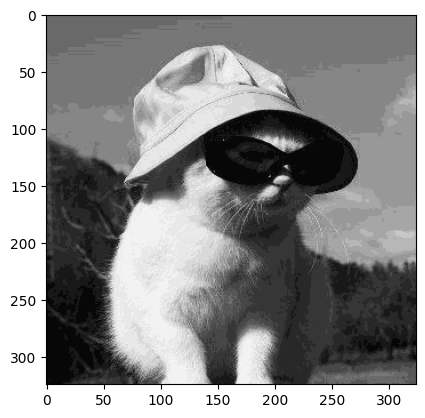

In [105]:
fname = 'cat.png'
image = Image.open(fname).convert("L")
cat_arr = np.asarray(image, dtype=float)
plt.imshow(cat_arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [130]:
# Erro Não consegui corrigir a tempo :(
eigenV = EigenV(max_it=100)
USV = eigenV.svd(cat_arr)

C:\Users\jorge\AppData\Local\Temp\ipykernel_9528\1940219748.py:102: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(US['D'])


LinAlgError: Singular matrix

In [132]:
k = 10

U = USV['U'][:, :k]
S = USV['S'][:k, :k]
V = USV['V'][:, :k].transpose()

Ak = np.matmul(np.matmul(U, S), V)
plt.imshow(Ak, cmap='gray', vmin=0, vmax=255)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### Questão 2 (Interpolação)

Definição da classe Interpolate, com métodos que serão úteis para implementações desta questão

In [133]:
"""
Classe Interpolate

Cálculo de interpolação de curvas polinomiais para pontos discretizados
"""
class Interpolate:
  def __init__(self, x_i, y_i) -> None:
    """ Construtor

    x_i : list 
      Vetor de pontos para interpolação (coord x)
    y_i : list 
      Vetor de pontos para interpolação (coord y)
    """
    self.x_i = np.array(x_i)
    self.y_i = np.array(y_i)
    self.n = len(self.x_i)

  def lagrange(self, x):
    """
    Obtenção de interpolação via método de Lagrange

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
    
    :returns: float
      Coordenada y com valor de interpolação
    """
    L = []

    for k in range(self.n):
      l_ki = lambda x, k, i : (x - self.x_i[i]) / (self.x_i[k] - self.x_i[i])
      l_k = lambda x, k : np.prod([l_ki(x,k,i) for i in range(self.n) if i != k])

      L.append(self.y_i[k] * l_k (x,k))

    return np.sum(L)
  
  def newton(self, x):
    """
    Obtenção de interpolação via método de Newton

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
    
    :returns: float
      Coordenada y com valor de interpolação
    """

    D = np.zeros((self.n, self.n))
    D[:, 0] = self.y_i

    for j in range(1,self.n):
      for i in range(self.n-j):
        divided_diff = lambda i,j : (D[i+1, j-1] - D[i,j-1]) / (self.x_i[i+j] - self.x_i[i])

        D[i,j] = divided_diff(i,j)

    p_ki = lambda x, ord_i : np.prod([(x - self.x_i[i]) for i in range(ord_i)])
    P_k = [D[0,i] * p_ki(x, i) for i in range(self.n)]

    return np.sum(P_k)
  
  @staticmethod
  def chebychev_nodes(a, b, n):
    """
    Obtenção de pontos espaçados via método de Chebychev

    :param a: float
      Limite inferior
    
    :param b: float
      Limite superior

    :returns: list
      Vetor de pontos (coord x) 
    """
    theta = lambda i : ((2*i - 1) / (2*(n+1))) * np.pi
    cheb_xi = lambda i : ((a+b)/2) + ((b-a)/2) * np.cos(theta(i))

    return [cheb_xi(i) for i in range(1,n)]
  
  def linear_spline(self, x):
    """
    Obtenção de interpolação via método de spline (linear)

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
  
    :returns: float
      Coordenada y com valor de interpolação
    """
    m_i = lambda i : ((self.x_i[i+1] - x) / (self.x_i[i+1] - self.x_i[i]))
    m_inext = lambda i : ((x - self.x_i[i]) / (self.x_i[i+1] - self.x_i[i]))
    
    s_i = lambda i : self.y_i[i] * m_i(i) + self.y_i[i+1] * m_inext(i)

    first_max_i = [i for i in range(1,self.n) if self.x_i[i-1] <= x]
    if len(first_max_i) == 0: return 0

    return s_i(first_max_i[-1]-1)
  
  def cubic_spline(self, x):
    """
    Obtenção de interpolação via método de spline (cúbica)

    :param x: float
      Coordenada x para o qual será calculada curva de interpolação
  
    :returns: float
      Coordenada y com valor de interpolação
    """
    h = self.x_i[2:] - self.x_i[1:self.n-1]
    u = 2 * [h[1:self.n-1] + h[2:self.n]]
    print(h)
    print(u)
    
    # a_i = lambda i : (z[i+1] - z[i]) / 6 h[i]
    # b_i = lambda i : z[i] / 2
    # c_i = lambda i : ((self.y_i[i+1] - self.y_i[i]) / h[i]) - (h[i] * z[i+1]) / 6 - (h[i] * z[i]) / 3
    # d_i = lambda i : self.y_i[i]

    first_max_i = [i for i in range(1,self.n) if self.x_i[i-1] <= x]
    if len(first_max_i) == 0: return 0

    # s_i(first_max_i[-1]-1)
  
  def least_square(self, k):
    """
    Obtenção de interpolação via método de mínimos quadrados

    :param k: int
      ordem da potência máxima do polinômio
  
    :returns: ndarray
      Coeficientes do polinômio de grau k 
    """
    X = np.vander(self.x_i, k)
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(self.y_i)
    a = np.linalg.solve(A, b)

    return a
    
  def least_square_qr(self, k):
    """
    Obtenção de interpolação via método de mínimos quadrados (usando QR)

    :param k: int
      ordem da potência máxima do polinômio
  
    :returns: ndarray
      Coeficientes do polinômio de grau k 
    """
    X = np.vander(self.x_i, k)
    (Q, R) = np.linalg.qr(X)
    b = np.transpose(X).dot(self.y_i)
    a = np.linalg.solve(R, b)

    return a  

##### a) Implemente as interpolações de Lagrange e de Newton

Métodos implementados na classe acima descrita, mas aproveito este item para derivar ambos os métodos

Podemos descrever a formulação de Lagrange da seguinte forma

Seja uma função qualquer $f(x)$ amostrada pelos pontos $y_i = f(x_i)$, $i = 0, 1, 2, ..., n$, queremos aproximá-la pelo polinômio de ordem $n$ $P_n(x)$ 

$$
P_n(x) = a_0 + a_1x + ... + a_nx^n
$$

Temos que $y_i = P_n(x_i)$

E portanto, 

$$
P_n(x) = y_0 + y_1l_1 + ... + y_nl_n
$$

Podemos reescrever da forma

$$
P_n(x) = \sum_{k=0}^n y_kl_k(x)
$$

onde $l_k(x_i) = \delta_{ik}$ (função delta de dirak)



Dessa forma, para $i \neq k$ $l_k(x_i) = 0$ e portanto $x_i$ é raiz de $P_n(x)$

Sendo $x_i$, com $i = 0, 1, 2, ..., k-1, k+1, ..., n$ raizes, temos válido que

$$
l_k(x) = a \prod_{i=0, i\neq k}^n (x-x_i) = 1
$$

E portanto, com $k = 0, 1, 2, ..., n$ temos o polinômio de Lagrange

$$
l_k(x) = \prod_{i=0,i \neq k}^{n} \frac{x-x_i}{x_k - x_i}
$$

Já para o método de Newton, partimos do polinômio cuja forma considera os pontos amostrados como "raízes", fazendo com que a notação de $P_n(x)$ seja

$$
P_n(x) = \alpha _0 + \alpha _1 (x-x_0) + \alpha _2 (x-x_0)(x-x_1) + ... + \alpha _n (x-x_0)(x-x_1)...(x-x_{n-1})
$$

onde $a_k$ representa a diferença dividida, com $k = 0, 1, 2, ..., n$

$$ a_k = f[x_0, x_1, ..., x_k] $$

Assim, temos

$$
\begin{align*}
  \alpha _0 &= f[x_0] \\
  \alpha _1 &= f[x_0,x_1] \\
  ... \\
  \alpha _n &= f[x_0,x_1,...,x_n] \\
\end{align*}
$$

##### b) Usando 11 pontos igualmente espaçados, calcule a interpolação de Lagrange e Newton para a função $f(t)$ dada

Sendo $f(t)$ dada por

$$
f(t) = \frac{1}{1+25 t^2}
$$

com $t \in [-1,1]$

In [134]:
fRungPhen = lambda x : 1 / (1 + (25 * (x**2)))
x_i = np.linspace(-1,1, 11)
y_i = [fRungPhen(x) for x in x_i]

interpolate = Interpolate(x_i, y_i)

In [135]:
x_runge = np.arange(-1,1,0.01)
f_runge = [fRungPhen(x) for x in x_runge]

xs = np.arange(-1,1.01,0.01)

L_lagrange = [interpolate.lagrange(x) for x in xs]
L_newton = [interpolate.newton(x) for x in xs]

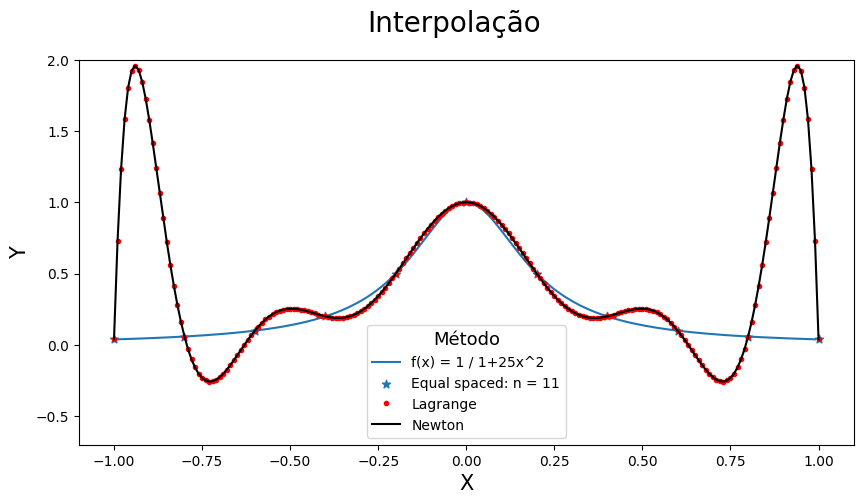

In [136]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, L_lagrange, '.r', label='Lagrange')
ax.plot(xs, L_newton, '-k', label='Newton')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

Como podemos verificar, ambos os métodos geram a mesma curva de interpolação.

Isso porque, conforme descrito no item anterior, ambas as formulações partem de uma equação polinomial cujos pontos amostrados pertencem à curva

Como exite apenas um único polinômio de grau $n$ que passa por $n-1$ pontos (raizes), ambas abordagens resultam em um mesmo polinômio

Outra forma de descrever esse fato ocorre através do determinante da matriz de Vandermonde

Se impomos a condição de que existe um polinômio $P_n(x)$ que interpola os pontos $(x_i, y_i)$, com $i = 0,1,2,...,k$.

$$
P_n(x) = a_0 + a_1 x + a_2 x^2 + ... + a_nx^n
$$

Podemos escreve-lo de forma matricial $Ma = y$


$$

\left[
\begin{array}{cccc}
  1 & x_0 & x_0^2 & ... & x_0^n \\
  1 & x_1 & x_1^2 & ... & x_1^n \\
  1 & x_2 & x_2^2 & ... & x_2^n \\
  ... & ... & ... & ... & ...  \\
  1 & x_n & x_n^2 & ... & x_n^n \\
\end{array}
\right]
\left[
\begin{array}{c}
  a_0 \\
  a_1 \\
  a_2 \\
  ... \\
  a_n \\
\end{array}
\right]
=
\left[
\begin{array}{c}
  y_0 \\
  y_1 \\
  y_2 \\
  ... \\
  y_n \\
\end{array}
\right]

$$

Como 

$$ det(X) = \prod_{i<k} (x_k - x_i) $$

E como $x_k \neq x_i$, então $det(X) \neq 0$. Portanto a solução do sistema linear dado por $a$ é única

Como $a$ representa os coeficientes do polinômio de interpolação, todos os possíveis polinômios que interpolam os pontos são o mesmo

##### c) Repita o processo com 21 pontos

In [139]:
x_i = np.linspace(-1,1, 21)
y_i = [fRungPhen(x) for x in x_i]

interpolate = Interpolate(x_i, y_i)

In [140]:
x_runge = np.arange(-1,1,0.01)
f_runge = [fRungPhen(x) for x in x_runge]

xs = np.arange(-1,1.01,0.01)

L_lagrange = [interpolate.lagrange(x) for x in xs]
L_newton = [interpolate.newton(x) for x in xs]

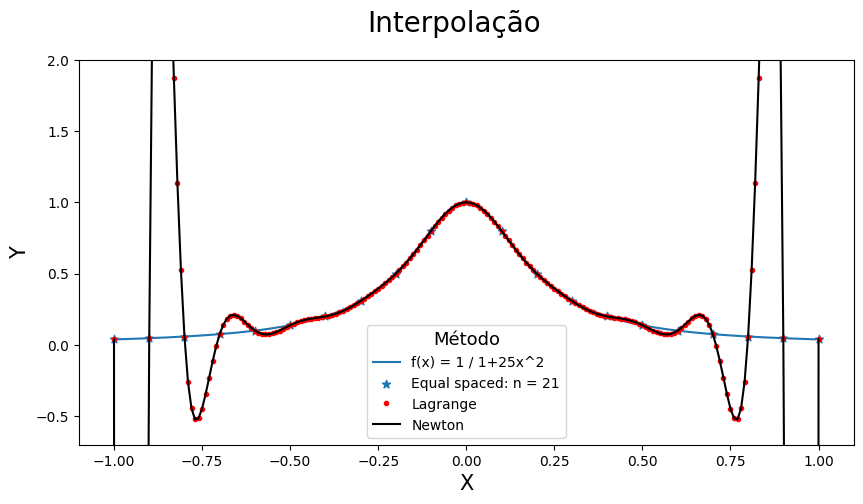

In [141]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, L_lagrange, '.r', label='Lagrange')
ax.plot(xs, L_newton, '-k', label='Newton')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

Notamos que nos extremos do intervalo $[-1,1]$ o erro entre o polinômio de interpolação e a função $f(x)$ interpolada aumenta substancialmente

##### d) Calcule a interpolação usando spline linear e cúbica

In [182]:
xs = np.arange(-1,1.01,0.01)
y_spline = [interpolate.linear_spline(x) for x in xs]

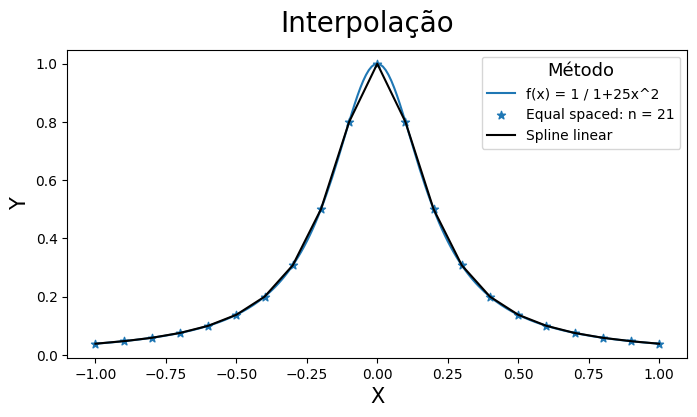

In [183]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, y_spline, '-k', label='Spline linear')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

plt.show()

In [184]:
from scipy import interpolate as scipyInterp
x_i = np.linspace(-1,1, 21)
y_i = [fRungPhen(x) for x in x_i]

y_spline3 = scipyInterp.CubicSpline(x_i, y_i)

xs = np.arange(-1,1.01,0.01)

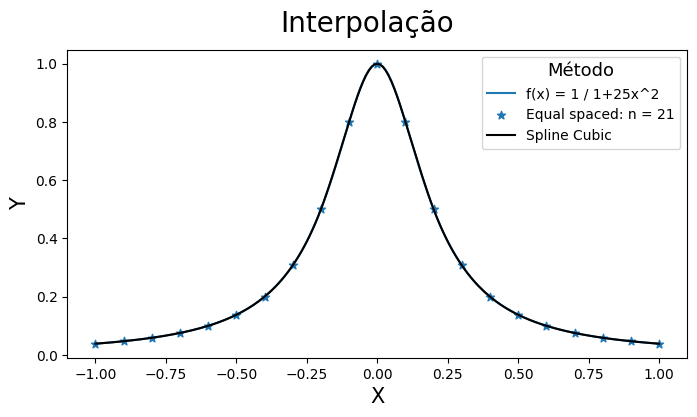

In [185]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_i, y_i, marker='*', label=f'Equal spaced: n = {len(x_i)}')
ax.plot(xs, y_spline3(xs), '-k', label='Spline Cubic')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

plt.show()

##### e) Repita os itens b) e c) com nós de Chebiychev

In [186]:
x_cheb = Interpolate.chebychev_nodes(-1.1,1,16)
y_cheb = [fRungPhen(x) for x in x_cheb]

xs = np.arange(-1,1.01,0.01)

interpolate = Interpolate(x_cheb, y_cheb)
L_cheb = [interpolate.lagrange(x) for x in xs]

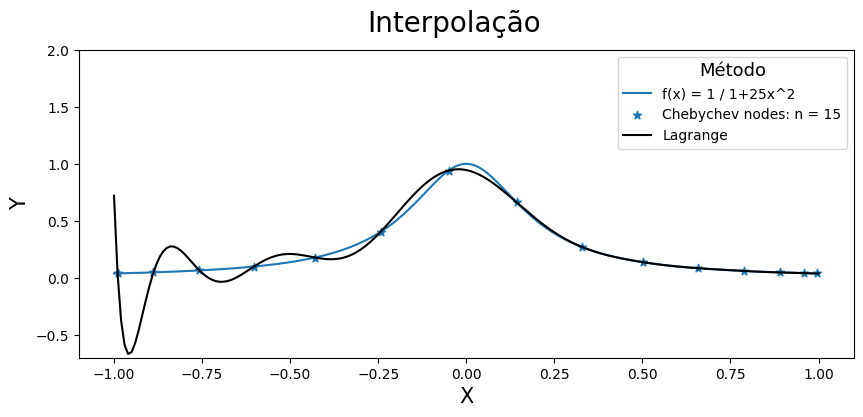

In [187]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_cheb, y_cheb, marker='*', label=f'Chebychev nodes: n = {len(x_cheb)}')
ax.plot(xs, L_cheb, '-k', label='Lagrange')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.7, 2)

plt.show()

In [188]:
x_cheb = Interpolate.chebychev_nodes(-1,1,22)
y_cheb = [fRungPhen(x) for x in x_cheb]

xs = np.arange(-1,1.01,0.01)

interpolate = Interpolate(x_cheb, y_cheb)
L_cheb = [interpolate.lagrange(x) for x in xs]

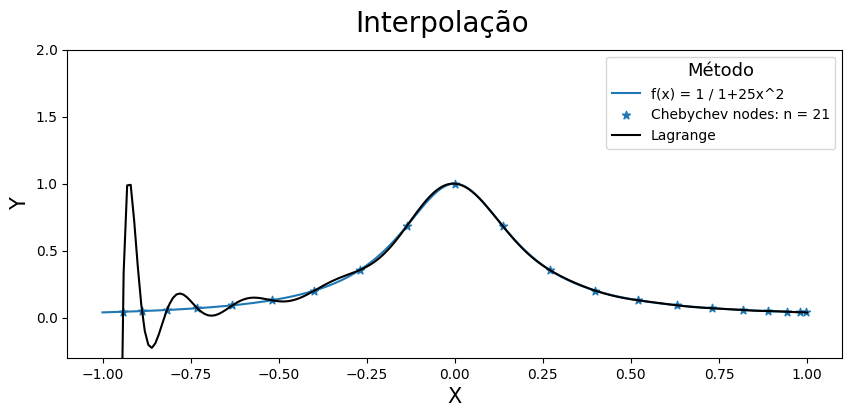

In [189]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Interpolação', fontsize=20)

ax.plot(x_runge, f_runge, '-', label='f(x) = 1 / 1+25x^2')
ax.scatter(x_cheb, y_cheb, marker='*', label=f'Chebychev nodes: n = {len(x_cheb)}')
ax.plot(xs, L_cheb, '-k', label='Lagrange')

ax.set_xlabel('X', {'size': 15})
ax.set_ylabel('Y', {'size': 15})
ax.legend(title='Método', title_fontsize=13)

ax.set_ylim(-0.3, 2)

plt.show()

A amostragem de pontos utilizando os nós de Chebychev melhoram os resultados obtidos para a interpolação polinomial via Newton e Lagrange pois escolhe pontos de modo não uniforme tais que minimizam a função de erro entre o polinômio e a curva 

#### Questão 3 (Minimos Quadrados)

Utilizaremos as funções fornecidas e que estão agregadas na classe Interpolate definida na questao anterior

##### a) Explique cada um dos códigos

In [190]:
"""  
def least_square(self, k):
  X = np.vander(self.x_i, k)
  A = np.transpose(X).dot(X)
  b = np.transpose(X).dot(self.y_i)
  a = np.linalg.solve(A, b)

  return a
  
def least_square_qr(self, k):
  X = np.vander(self.x_i, k)
  (Q, R) = np.linalg.qr(X)
  b = np.transpose(X).dot(self.y_i)
  a = np.linalg.solve(R, b)

  return a
"""

'  \ndef least_square(self, k):\n  X = np.vander(self.x_i, k)\n  A = np.transpose(X).dot(X)\n  b = np.transpose(X).dot(self.y_i)\n  a = np.linalg.solve(A, b)\n\n  return a\n  \ndef least_square_qr(self, k):\n  X = np.vander(self.x_i, k)\n  (Q, R) = np.linalg.qr(X)\n  b = np.transpose(X).dot(self.y_i)\n  a = np.linalg.solve(R, b)\n\n  return a\n'

Em resumo, o método dos Mínimos Quadrados busca calcular uma função ou um conjunto de pontos que melhor aproximam uma função qualquer a uma função conhecida

Vamos tomar em primeiro momento a primeira função, least_square

Dado um polinômio de grau $k$ temos

$$
P_k(x) = a_0 + a_1 x + a_2 x^2 + ... + a_k x^k
$$

E dado um conjunto de $x_i$ pontos com $i = 0, 1, 2, ..., n$

Assim como construimos para o caso do método de interpolação, temos $P = Va$ tal que

$$

P = \left[
\begin{array}{cccc}
  1 & x_0 & x_0^2 & ... & x_0^k \\
  1 & x_1 & x_1^2 & ... & x_1^k \\
  1 & x_2 & x_2^2 & ... & x_2^k \\
  ... & ... & ... & ... & ...  \\
  1 & x_n & x_n^2 & ... & x_n^k \\
\end{array}
\right]
\left[
\begin{array}{c}
  a_0 \\
  a_1 \\
  a_2 \\
  ... \\
  a_k \\
\end{array}
\right]
$$

A matrix $V$ é o que obtemos nesta linha

--- X = np.vander(self.x_i, k) ---

Sabemos que um ponto (ou função) que melhor aproxima pontos de um espaço em outro é aquele que representa a projeção ortogonal do ponto dado no espaço conhecido sobre o qual desejamos mapea-lo

Para isso, precisamos portanto, para cada ponto, determinar sua projeção ortogonal no espaço de polinômios de grau $k$

Sendo $u_i = [x_0^i, x_1^i, x_2^i, ..., x_n^i]^T$ coordenadas dos pontos $x_0, x_1, ..., x_n$ no "eixo" $i$ e também sabendo que a projeção é dada pelo produto escalar entre dois vetores, precisamos calcular $\lang u_i, u_j \rang$, com $i,j = 0,1,2,...,k$

Além disso, como a projeção deve ser feita da coordenada $i$ sobre as demais coordenadas $j$, tal operação pode ser colocada na forma matricial dada por

$$
\left[
\begin{array}{cccc}
  \lang u_0, u_0 \rang & \lang u_0, u_1 \rang & \lang u_0, u_2 \rang & ... & \lang u_0, u_k \rang \\
  \lang u_1, u_0 \rang & \lang u_1, u_1 \rang & \lang u_1, u_2 \rang & ... & \lang u_1, u_k \rang \\
  \lang u_2, u_0 \rang & \lang u_2, u_1 \rang & \lang u_2, u_2 \rang & ... & \lang u_2, u_k \rang \\
  ... & ... & ... & ... & ...  \\
  \lang u_k, u_0 \rang & \lang u_k, u_1 \rang & \lang u_k, u_2 \rang & ... & \lang u_k, u_k \rang \\
\end{array}
\right]
$$

Que pode ser reescrita como

$$
A = \lang V^T V\rang
$$

com $V$ matriz de Vandermonde obtida acima

Essa matriz é o que obtemos na linha

--- A = np.transpose(X).dot(X) ---

Sendo $A$ obtido acima, precisamos por fim obter os coeficientes do polinômio tal que, quando aplicados sobre a matriz de transformação $A$ resulte no pontos amostrados projetados no nosso espaço de polinômios

Sendo a projeção dos pontos amostrados dada pela matriz $b$

$$
b = \left[
\begin{array}{cccc}
  \lang u_0, y \rang \\
  \lang u_1, y \rang \\
  \lang u_2, y \rang \\
  ...  \\
  \lang u_k, y \rang \\
\end{array}
\right]
$$

Esse cálculo ocorre na linha

--- b = np.transpose(X).dot(self.y_i) ---

Então tamos que os coeficientes do nosso polinômio são $\alpha = [a_0, a_1, ..., a_k]$ tais que

$$
A \alpha = p
$$

A solução desse sistema linear, que nos fornece $\alpha$ ocorre nesta linha

--- a = np.linalg.solve(A, b) ---

In [191]:
x_i = [-1, 0, 1, 2]
y_i = [0, -1, 0, 7]

In [192]:
interpolate = Interpolate(x_i, y_i)
interpolate.least_square(3)

array([ 2. ,  0.2, -1.6])

Nossa função retorna, portanto, uma lista com os coeficientes do polinômio. Tal retorno acima é compreendido como o polinômio

$$
P_2(x) = -1.6 + 0.2x + 2x^2
$$

##### b) Aproxime os dados do período completo para o arquivo de casos de Covid fornecido por uma função $g(x) = ab^x$

In [195]:
casos_por_dia = open('casosacumuladosbrasilatuaizado.txt').readlines()
y_i = np.array(list(map(lambda item: int(item.replace('\n', '')), casos_por_dia)))
y_i = np.log10(y_i)
x_i = np.arange(len(y_i))


Como queremos aproximar nossos dados pela função $g(x) = ab^x$ precisamos linearizá-la. Assim

$$

log \big( g(x) \big) = log\big( ab^x\big) = log(a) + x log(b)

$$

Sendo, assim, $h(x) = log\big(g(x)\big)$ $\alpha = log(a)$ e $\beta = log(b)$, temos o polinômio de grau 1 (reta)

$$
h(x) = \alpha + x \beta
$$

In [196]:
interpolate = Interpolate(x_i, y_i)
pol_coeff_ls = interpolate.least_square(2)
print(pol_coeff_ls)

beta = pol_coeff_ls[0]
alpha = pol_coeff_ls[1]

fy = lambda x : alpha + beta * x

[0.04585164 1.54793513]


In [197]:
x = np.linspace(0, len(x_i), 100)
y = [fy(i) for i in x]

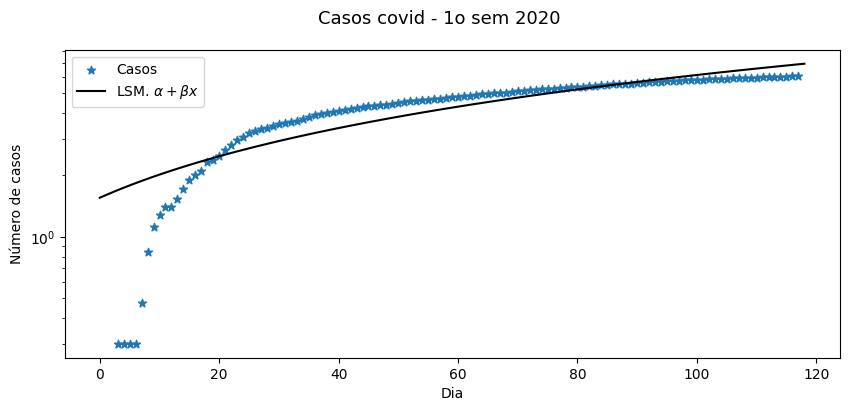

In [203]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Casos covid - 1o sem 2020', fontsize=13)
ax.scatter(x_i, y_i, marker='*', label=f'Casos')
ax.plot(x, y, '-k', label=r'LSM. $\alpha + \beta x$')

ax.set_yscale('log')
ax.legend(title_fontsize=10)
ax.set_ylabel('Número de casos')
ax.set_xlabel('Dia')

plt.show()

##### c) Repita o item b) usando apenas os primeiros 20 dias

OBS: Resposta combinada ao exercício e) (achei melhor colocar em gráficos lado a lado)

##### d) Repita o item b) usando apenas os últimos 50 dias

OBS: Resposta combinada ao exercício e) (achei melhor colocar em gráficos lado a lado)

##### e) Compare os itens b) c) e d_. Que tipo de informação os dados nos fornecem?

In [206]:
interpolate20 = Interpolate(x_i[:20], y_i[:20])
pol_coeff_ls_20 = interpolate20.least_square(2)
print(pol_coeff_ls_20)

beta20 = pol_coeff_ls_20[0]
alpha20 = pol_coeff_ls_20[1]

fy20 = lambda x : alpha20 + beta20 * x

[ 0.13726492 -0.2243594 ]


In [207]:
interpolate50 = Interpolate(x_i[50:], y_i[50:])
pol_coeff_ls_50 = interpolate50.least_square(2)
print(pol_coeff_ls_50)

beta50 = pol_coeff_ls_50[0]
alpha50 = pol_coeff_ls_50[1]

fy50 = lambda x : alpha50 + beta50 * x

[0.02365873 3.410505  ]


In [208]:
x = np.linspace(0, len(x_i), 100)
y20 = [fy20(i) for i in x]
y50 = [fy50(i) for i in x]

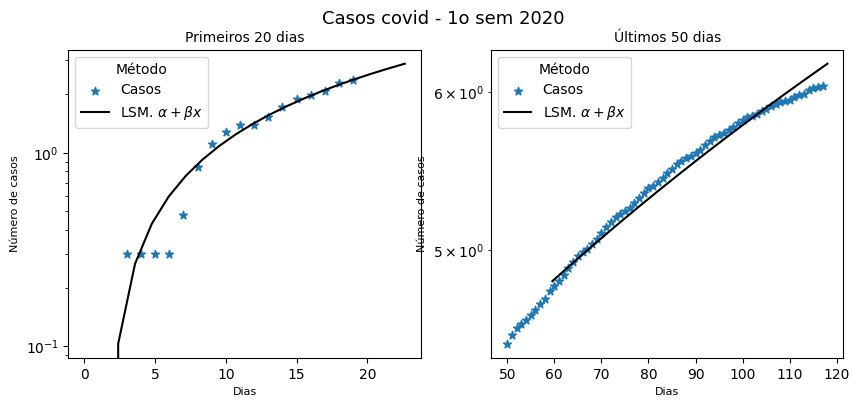

In [210]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

fig.suptitle('Casos covid - 1o sem 2020', fontsize=13)

ax[0].set_title('Primeiros 20 dias', fontsize=10)
ax[0].scatter(x_i[:20], y_i[:20], marker='*', label=f'Casos')
ax[0].plot(x[:20], y20[:20], '-k', label=r'LSM. $\alpha + \beta x$')

ax[0].set_yscale('log')

ax[0].set_xlabel('Dias', {'size': 8})
ax[0].set_ylabel('Número de casos', {'size': 8})
ax[0].legend(title='Método', title_fontsize=10)

ax[1].set_title('Últimos 50 dias', fontsize=10)
ax[1].scatter(x_i[50:], y_i[50:], marker='*', label=f'Casos')
ax[1].plot(x[50:], y50[50:], '-k', label=r'LSM. $\alpha + \beta x$')

ax[1].set_yscale('log')

ax[1].set_xlabel('Dias', {'size': 8})
ax[1].set_ylabel('Número de casos', {'size': 8})
ax[1].legend(title='Método', title_fontsize=10)

plt.show()

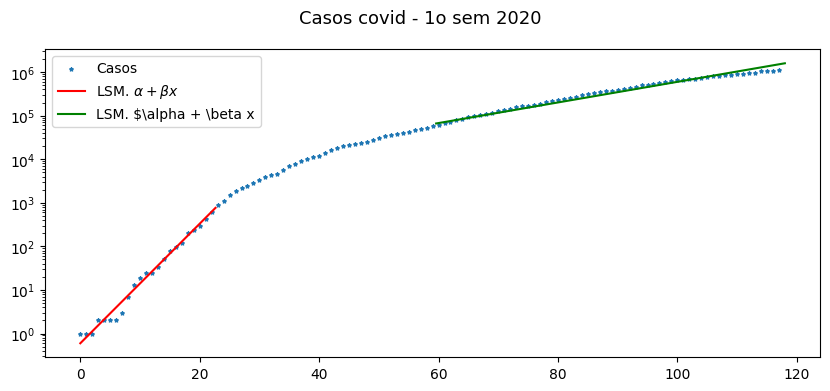

In [219]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

fig.suptitle('Casos covid - 1o sem 2020', fontsize=13)
ax.scatter(x_i, np.power(10, y_i), marker='*', s=7, label=f'Casos')
ax.plot(x[:20], np.power(10, y20[:20]), '-r', label=r'LSM. $\alpha + \beta x$')
ax.plot(x[50:], np.power(10, y50[50:]), '-g', label=r'LSM. $\alpha + \beta x')

ax.set_yscale('log')

ax.legend(title_fontsize=10)

plt.show()

Ao comparar os dados e as aproximações via mínimos quadrados para a função $g(x) = ab^x$ notamos que o crescimento, embora seja bem aproximado por uma função exponencial, apresenta coeficientes distintos ao longo do tempo

No início dos dados coletados, a função que melhor aproxima os dados é dada por

$$
g(x) \approx -0.224 (0.137)^x
$$

Por outro lado, para o período final dos dados considerados a função que melhor aproxima é dada por

$$
g(x) \approx 3.41 (0.0236)^x
$$

Isso porque em períodos iniciais o número de casos aumentou com uma taxa expressivamente distinta (0.137) daquela em que atingiu após um tempo (0.023).

Uma justificativa para essa diferença, considerando o que os dados representam, ocorre devido à acelerada taxa de infecção de novas pessoas assim que as primeiras pessoas são infectadas

Ao longo do tempo, como um número elevado de pessoas já encontra-se infectada, o número de novos casos tende a estabilizar, uma vez que as pessoas já foram infectadas pelo vírus

É por essa diferença de taxas que o gráfico obtido pela aproximação ao utilizar todo o período de dados não é representativa. Como existe uma diferença significativa da função que rege os dados ao longo do período, assumir que apenas uma função (com os mesmos coeficientes) seria suficiente para uma boa representação mostra-se uma hipótese incorreta